# 3c - Training Custom Spark Model <a class="anchor" id="top"></a>
* [Introduction](#intro)
* [Setup](#setup)
* [Loading the data](#load-data)
* [Model definition](#model)
* [Fit model and evaluate](#fit)
* [Serialize and store pipeline](#store)

## Introduction <a class="anchor" id="intro"></a>
In this section, we define and tain a custom Spark model.
The model will be based around Spark's perceptron implementation.
We then serialize the model to allow for deployment on an endpoint in the next section.

## Setup <a class="anchor" id="setup"></a>
First, we must import relevant Spark modules as well as libraries for statistical analysis and visualizations.
Note that will also start the Spark application that creates the `SparkSession` and sets it to the `spark` variable.

In [85]:
%%cleanup -f

In [55]:
import pyspark
import pyspark.ml as ml
import pyspark.sql as sql
import pyspark.sql.types as types
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
import mleap.pyspark.spark_support as support

import os
import json
import boto3
import shutil
import zipfile
import tarfile
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
s3 = boto3.resource("s3")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading the data <a class="anchor" id="load-data"></a>

Now, we load the training, validation, and test data from S3.
To do this, we must first get the bucket name where the data is stored.
This variable is stored on the local Sagemaker notebook instance during the `DevEnvironment` stack creation 
and must be explicitly passed to the Spark cluster.

In [3]:
%%local
import json
with open("/home/ec2-user/.aiml-bb/stack-data.json", "r") as f:
    data = json.load(f)
    data_bucket = data["data_bucket"]
    model_bucket = data["model_bucket"]

In [4]:
%%send_to_spark -i data_bucket -t str

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'data_bucket' as 'data_bucket' to Spark kernel

In [5]:
%%send_to_spark -i model_bucket -t str

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'model_bucket' as 'model_bucket' to Spark kernel

In [6]:
train_df = spark.read.csv(f"s3a://{data_bucket}/preprocessing_output/train/", inferSchema=True)
validation_df = spark.read.csv(f"s3a://{data_bucket}/preprocessing_output/validation/", inferSchema=True)
test_df = spark.read.csv(f"s3a://{data_bucket}/preprocessing_output/test/", inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
%%pretty
train_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,_c40,_c41,_c42,_c43,_c44,_c45,_c46,_c47,_c48,_c49,_c50,_c51,_c52,_c53,_c54,_c55,_c56,_c57,_c58,_c59,_c60,_c61,_c62,_c63,_c64,_c65,_c66,_c67,_c68,_c69,_c70,_c71,_c72,_c73,_c74,_c75,_c76,_c77,_c78,_c79
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.3632772872402005,-0.26679504200489773,0.0,0.0,0.0,1.8263820885807576,0.43889919287823387,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0339430482990322,0.27667633985693096,0.0,0.0,0.0,2.5607006602781754,1.6658219366060238,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0339430482990322,0.27667633985693096,0.0,0.0,0.0,1.9864258798481436,1.386522450228966,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.726554574480401,-0.20750725489269822,0.0,0.0,0.8303506324339892,1.8263820885807576,0.7780485691932327,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0339430482990322,0.27667633985693096,0.0,0.0,0.0,2.7207444515455617,1.6658219366060238,0.0,0.0,0.0


## Model definition <a class="anchor" id="model"></a>
For this task, we will be testing Spark's `MultilayerPerceptronClassifier`, which is a feedforward artificial neural network.
This was chosen becuse perceptron's can yield desirable results when the training set is large, as  is the case here.
Also, there is no direct analog implemented as a Sagemaker built-in algorithm at the time of writing, so this makes for a good example of an advantage of this method.

In [59]:
# Need to wrap features into vector for training.
feature_assembler = ml.feature.VectorAssembler(
    inputCols=train_df.columns[1:], 
    outputCol="features",
    handleInvalid="keep"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
# Define perceptron layers. For this architecture, we are 
# choosing two dense hidden layers with 256 and 128 
# respsectively. For classification, Spark's perceptron 
# implementation requires the number of output nodes to be
# the number of classes.
layers = [
    len(train_df.columns[1:]), # Number of inputs.
    256,
    128,
    2 # Number of outputs.
]
mlp_classifier = ml.classification.MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol=train_df.columns[0],
    predictionCol="prediction",
    layers=layers,
    maxIter=100,
    blockSize=512
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
# Wrap steps into pipeline.
# Define Pipeline object.
inference_pipeline = ml.Pipeline(
    stages=[
        feature_assembler,
        mlp_classifier
    ]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Fit model and evaluate <a class="anchor" id="fit"></a>
Fit the model to the training data and predict values on the testing.
We then analyze the model using Spark's built in evaluators.

In [ ]:
# Train the model on the training data and transform 
# the test data.
inference_model = inference_pipeline.fit(train_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
transformed_test_df = inference_model.transform(validation_df)

In [77]:
%%pretty
transformed_test_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,_c40,_c41,_c42,_c43,_c44,_c45,_c46,_c47,_c48,_c49,_c50,_c51,_c52,_c53,_c54,_c55,_c56,_c57,_c58,_c59,_c60,_c61,_c62,_c63,_c64,_c65,_c66,_c67,_c68,_c69,_c70,_c71,_c72,_c73,_c74,_c75,_c76,_c77,_c78,_c79,features,rawPrediction,probability,prediction
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7046088093578637,0.9881297852033248,0.0,0.0,0.0,2.8807882428129474,1.9949963312646992,0.0,0.0,0.0,"(79,[0,14,26,39,6...",[0.98429395358786...,[0.69229170765959...,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7604976227794331,0.9881297852033248,0.0,0.0,0.0,2.7207444515455617,2.324170725923375,0.0,0.0,0.0,"(79,[0,14,26,39,6...",[0.91825534040698...,[0.66606224923162...,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8070716339640742,0.7114534453463939,0.0,0.0,0.0,2.7207444515455617,2.324170725923375,0.0,0.0,0.0,"(79,[0,14,34,39,6...",[0.98872177759226...,[0.69072401120909...,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.6580347981732226,0.8794355088309591,0.0,0.0,0.0,2.8807882428129474,1.9949963312646992,0.0,0.0,0.0,"(79,[0,14,26,39,6...",[0.99016446033114...,[0.69495560034484...,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7046088093578637,0.9881297852033248,0.0,0.0,0.0,2.5607006602781754,2.3840206158613158,0.0,0.0,0.0,"(79,[0,14,26,39,6...",[0.88358464275883...,[0.65233984541049...,0.0


In [78]:
# Create objects to compute metrics on performance.
evaluator = ml.evaluation.BinaryClassificationEvaluator(
    labelCol=transformed_test_df.columns[0],
    rawPredictionCol="prediction"
)
metrics = MulticlassMetrics(
    transformed_test_df.select(
        "prediction",
        transformed_test_df.columns[0]
     ).rdd
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
# Compute summary statistics on perfomance.
performance_statistics = {
    "accuracy": metrics.accuracy,
    "precision": metrics.precision(),
    "recall": metrics.recall(),
    "f1": metrics.fMeasure(),
    "auc": evaluator.evaluate(transformed_test_df, {evaluator.metricName: "areaUnderROC"}),
}
print(json.dumps(performance_statistics, indent=4))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{
    "accuracy": 0.6107066229199383,
    "precision": 0.6107066229199383,
    "recall": 0.6107066229199383,
    "f1": 0.6107066229199383,
    "auc": 0.6106936495658308
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

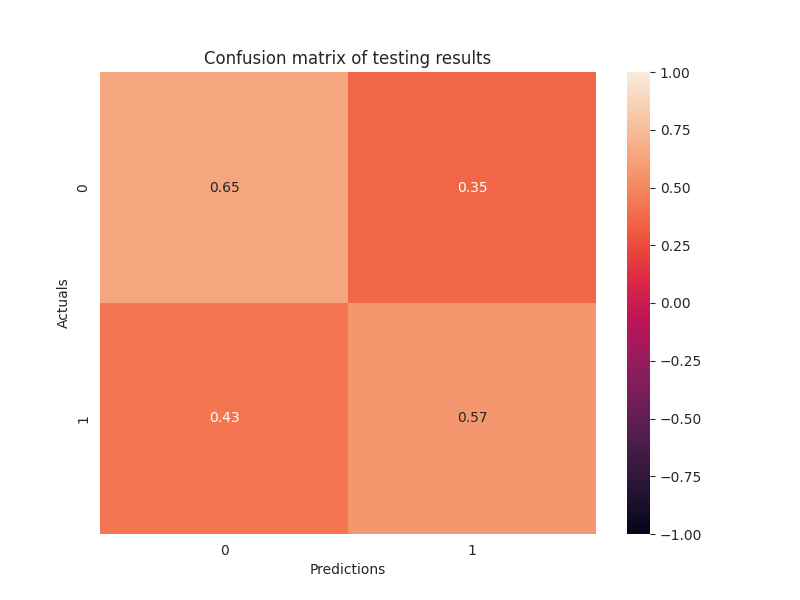

In [80]:
# Compute confusion matrix.
confusion_np = metrics.confusionMatrix().toArray()
norm_confusion_np = confusion_np / confusion_np.sum(axis=1)

# Show confusion matrix.
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    norm_confusion_np, 
    vmin=-1.0, vmax=1.0, annot=True, fmt=".2f", 
    ax=ax
)
ax.set_xlabel("Predictions")
ax.set_ylabel("Actuals")
ax.set_title("Confusion matrix of testing results")
%matplot plt

## Serialize and store pipeline <a class="anchor" id="store"></a>
Spark pipelines and estimators must be serialized with MLeap to use with a Sagemaker model.
Sagemaker will then read the model from S3 to use with a built SparkML image.

In [83]:
# Serialize preproccesing pipeline.
serializer = support.SimpleSparkSerializer()
serializer.serializeToBundle(
    inference_model, 
    "jar:file:/tmp/model.zip", 
    transformed_test_df
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
# Convert model zipfile to tarfile.
with zipfile.ZipFile("/tmp/model.zip") as zf:
    zf.extractall("/tmp/model")

with tarfile.open("/tmp/model.tar.gz", "w:gz") as tar:
    tar.add("/tmp/model/bundle.json", arcname="bundle.json")
    tar.add("/tmp/model/root", arcname="root")

# Write model to S3.
s3 = boto3.resource("s3")
filename = "spark-perceptron/model.tar.gz"
s3.Bucket(model_bucket).upload_file("/tmp/model.tar.gz", filename)

# Clean up local environment.
os.remove("/tmp/model.zip")
os.remove("/tmp/model.tar.gz")
shutil.rmtree("/tmp/model")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…